In [1]:
from pathlib import Path
import sys
sys.path.append('../bitome-kb/')
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from bitome.core import Bitome
from Bio.SeqFeature import FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq

from math import log,exp,inf

import logomaker as lm
import Bio.motifs as motifs
bitome = Bitome.init_from_file('../bitome-kb/bitome.pkl')

In [4]:
bitome_U00096 = Bitome(Path('data/e_coli_genomes/prokka', 'U00096.gb'))
bitome_U00096.load_data(regulon_db=False)

In [5]:
shape = pd.read_pickle('../../K12DNA_structure/ecoli_U00096/ecoli_U00096_shape.pickle')

In [6]:
shape.head()

HelT   Roll  Shift  Slide   Rise   TilT  Buckle  Shear  Stretch  Stagger  \
3  35.265 -3.975 -0.170 -1.805  3.510  0.960   -3.03   0.25    -0.02     0.12   
4  34.675 -4.685 -0.260 -1.520  3.355  1.870   -8.27  -0.13     0.00     0.08   
5  36.940 -5.025 -0.030 -1.140  3.240  1.475   -7.39  -0.17     0.01    -0.13   
6  36.560 -3.465  0.195 -1.035  3.200  1.120   -6.00  -0.16    -0.01    -0.16   
7  35.625 -1.190  0.295 -1.235  3.255 -0.405   -1.41  -0.09    -0.03    -0.22   

   Opening   MGW   ProT     EP  loc  
3     0.37  4.14  -1.56  -6.03    3  
4    -0.74  4.03 -10.58  -8.76    4  
5    -2.30  3.68 -14.68 -10.39    5  
6    -2.28  4.35 -13.16  -9.65    6  
7    -1.24  5.40 -10.81  -7.56    7

In [7]:
def get_shape( start, end, shape_table ):
    start = start -3
    end = end -2
    result = shape_table.iloc[start:end,:]
    return result

In [8]:
get_shape(3,7,shape).drop(['loc'],axis=1)

HelT   Roll  Shift  Slide   Rise   TilT  Buckle  Shear  Stretch  Stagger  \
3  35.265 -3.975 -0.170 -1.805  3.510  0.960   -3.03   0.25    -0.02     0.12   
4  34.675 -4.685 -0.260 -1.520  3.355  1.870   -8.27  -0.13     0.00     0.08   
5  36.940 -5.025 -0.030 -1.140  3.240  1.475   -7.39  -0.17     0.01    -0.13   
6  36.560 -3.465  0.195 -1.035  3.200  1.120   -6.00  -0.16    -0.01    -0.16   
7  35.625 -1.190  0.295 -1.235  3.255 -0.405   -1.41  -0.09    -0.03    -0.22   

   Opening   MGW   ProT     EP  
3     0.37  4.14  -1.56  -6.03  
4    -0.74  4.03 -10.58  -8.76  
5    -2.30  3.68 -14.68 -10.39  
6    -2.28  4.35 -13.16  -9.65  
7    -1.24  5.40 -10.81  -7.56

In [9]:
def read_blast( fname ):
    hits = {}
    ffile = open(fname, "rt")
    lines = ffile.readlines()
    ffile.close()
    for line in lines:
        if line[0] != '"':
            continue    
        sline = line.replace('"','').strip()
        sline_list = sline.split('\t')
        if sline_list[0] not in hits.keys():
            hits[ sline_list[0] ] = {'TU_id': sline_list[0] ,'subject': sline_list[1],
                                     'q_start':int(sline_list[8]),'q_end':int(sline_list[9]),
                                     'length':int(sline_list[3]) }
    return hits   

In [10]:
hits_U00096 = read_blast( 'blast_fasta/ecoli_U00096_blast.txt')
TU_U00096 = []

for g in bitome.genes:
    if len(g.transcription_units) < 1:
        continue
        
    for tu in g.transcription_units:
        if tu.id not in hits_U00096.keys():
            continue
        if tu.tss==None:
            continue
        
        data = {}
        data['ID'] = g.locus_tag
        data['gene'] = g.name
        data['TU'] = tu.name
        data['TU_id'] = tu.id
        data['strand'] = tu.location.strand
        if data['strand'] == 1:
            data['TSS_pred'] = hits_U00096[tu.id]['q_start']
        else:
            data['TSS_pred'] = hits_U00096[tu.id]['q_start']
            
        data['start'] = hits_U00096[tu.id]['q_start']
        data['end'] = hits_U00096[tu.id]['q_end']
        data['length'] = hits_U00096[tu.id]['length']
        TU_U00096.append(data)

TU_U00096_table = pd.DataFrame(TU_U00096)
TU_U00096_table.head()

ID  gene       TU         TU_id  strand  TSS_pred  start   end  length
0  b0001  thrL  thrLABC  ECK120009369       1       148    148  5076    4929
1  b0001  thrL     thrL  ECK125145761       1       148    148   465     318
2  b0002  thrA  thrLABC  ECK120009369       1       148    148  5076    4929
3  b0003  thrB  thrLABC  ECK120009369       1       148    148  5076    4929
4  b0004  thrC  thrLABC  ECK120009369       1       148    148  5076    4929

## Extract known TSS and strand information

In [11]:
tss_strand_tups = []
for i in range(len(TU_U00096_table['ID'])):
    tu_tss =   int(TU_U00096_table['TSS_pred'][i])
    tu_strand = int(TU_U00096_table['strand'][i])
    
    tss_strand_tups.append((tu_tss, tu_strand))
    
unique_tss_strand_tups = list(set(tss_strand_tups))

In [12]:
N_UPSTREAM = 200
N_DOWNSTREAM = 100
AT_PLUS_MINUS = 5

shape_names = ['HelT', 'Roll', 'Shift', 'Slide', 'Rise', 'TilT', 'Buckle', 'Shear',
               'Stretch', 'Stagger', 'Opening', 'MGW', 'ProT', 'EP']

upstream_shape_df = pd.DataFrame(columns=(shape_names + ['bp', 'AT']))

for tss, strand in unique_tss_strand_tups:

    if strand == 1:
        
        # ignore the case where we have to wrap around for now; just excludes a couple of TSS
        if tss < N_UPSTREAM:
            continue
        
        locs = np.arange(tss - N_UPSTREAM, tss + N_DOWNSTREAM + 1)
        bp_to_tss = np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1)
        
        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            tss - N_UPSTREAM - AT_PLUS_MINUS - 1,
            tss + N_DOWNSTREAM + AT_PLUS_MINUS,
            strand
        )
        
    else:

        locs = np.arange(tss - N_DOWNSTREAM, tss + N_UPSTREAM + 1)
        bp_to_tss = np.flip(np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1))

        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            tss - N_DOWNSTREAM - AT_PLUS_MINUS - 1,
            tss + N_UPSTREAM + AT_PLUS_MINUS,
            strand
        )
    
    tss_shape_df = get_shape(locs[0], locs[-1], shape ).drop(['loc'],axis=1)
    tss_shape_df['bp'] = bp_to_tss
    
    sequence = seq_loc.extract(bitome_U00096.sequence)
    at_content = []
    for i in range(AT_PLUS_MINUS, N_UPSTREAM + N_DOWNSTREAM + AT_PLUS_MINUS + 1):
        seq_slice = sequence[i-AT_PLUS_MINUS:i+AT_PLUS_MINUS+1]
        at_count = 0
        for base in seq_slice:
            if base in ['A', 'T']:
                at_count += 1
        at_content.append(at_count/(2*AT_PLUS_MINUS + 1))
    
    # we computed AT content in sequence order, REGARDLESS of strand; but we're feeding
    # the bp in reverse order for the reverse strand; swap the AT content list in that case
    if strand == -1:
        at_content.reverse()
    
    tss_shape_df['AT'] = at_content
    
    
    upstream_shape_df = upstream_shape_df.append(tss_shape_df)

In [13]:
# take the absolute value of Roll
upstream_shape_df.loc[:, 'Roll'] = upstream_shape_df['Roll'].abs()

In [14]:
import seaborn as sns

In [38]:
avg_df_idx = np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1)
shape_avg_df = pd.DataFrame(index=avg_df_idx, columns=['AT'] + shape_names)
for bp in avg_df_idx:
    bp_shape_df = upstream_shape_df[upstream_shape_df['bp'] == bp]
    bp_avg = bp_shape_df.drop(columns='bp').mean(axis=0)
    shape_avg_df.loc[bp, :] = bp_avg

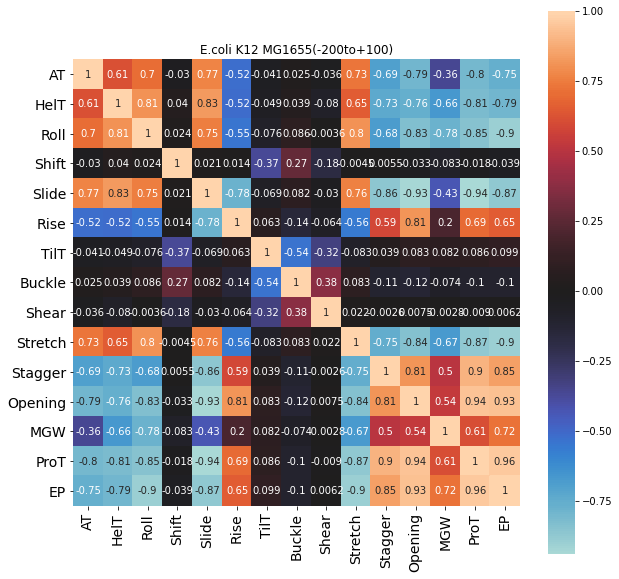

In [41]:
shape_avg_df = shape_avg_df.astype(float)
corr_df = shape_avg_df.corr(method='spearman')

_, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_df, center=0, annot=True, square=True, ax=ax)
ax.set_title('E.coli K12 MG1655(-200to+100)')
ax.tick_params(axis='both', labelsize=14)
ax.tick_params(axis='y', rotation=0)

## Boostrap Random TSS/Strand Tuples and Do the Same Calculations

In [42]:
N_BOOTSTRAP = len(unique_tss_strand_tups)

random_tss_strand_tups = []
buffer = max(N_UPSTREAM, N_DOWNSTREAM)
tss_pool = np.arange(buffer, len(bitome_U00096.sequence) - buffer)
for i in range(N_BOOTSTRAP):
    tss = int(np.random.choice(tss_pool))
    strand = int(np.random.choice([-1, 1]))
    random_tss_strand_tups.append((tss, strand))

random_shape_df = pd.DataFrame(columns=(shape_names + ['bp', 'AT']))

for tss, strand in random_tss_strand_tups:

    if strand == 1:
        
        # ignore the case where we have to wrap around for now; just excludes a couple of TSS
        if tss < N_UPSTREAM:
            continue
        
        locs = np.arange(tss - N_UPSTREAM, tss + N_DOWNSTREAM + 1)
        bp_to_tss = np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1)
        
        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            tss - N_UPSTREAM - AT_PLUS_MINUS - 1,
            tss + N_DOWNSTREAM + AT_PLUS_MINUS,
            strand
        )
        
    else:

        locs = np.arange(tss - N_DOWNSTREAM, tss + N_UPSTREAM + 1)
        bp_to_tss = np.flip(np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1))

        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            tss - N_DOWNSTREAM - AT_PLUS_MINUS - 1,
            tss + N_UPSTREAM + AT_PLUS_MINUS,
            strand
        )
    
   
    tss_shape_df = get_shape(locs[0], locs[-1], shape ).drop(['loc'],axis=1)
    tss_shape_df['bp'] = bp_to_tss
    
    sequence = seq_loc.extract(bitome_U00096.sequence)
    at_content = []
    for i in range(AT_PLUS_MINUS, N_UPSTREAM + N_DOWNSTREAM + AT_PLUS_MINUS + 1):
        seq_slice = sequence[i-AT_PLUS_MINUS:i+AT_PLUS_MINUS+1]
        at_count = 0
        for base in seq_slice:
            if base in ['A', 'T']:
                at_count += 1
        at_content.append(at_count/(2*AT_PLUS_MINUS + 1))
    
    # we computed AT content in sequence order, REGARDLESS of strand; but we're feeding
    # the bp in reverse order for the reverse strand; swap the AT content list in that case
    if strand == -1:
        at_content.reverse()
    
    tss_shape_df['AT'] = at_content
    
    random_shape_df = random_shape_df.append(tss_shape_df)

In [43]:
# take the absolute value of Roll
random_shape_df.loc[:, 'Roll'] = random_shape_df['Roll'].abs()

In [44]:
random_shape_avg_df = pd.DataFrame(index=avg_df_idx, columns=['AT'] + shape_names)
for bp in avg_df_idx:
    bp_shape_df = random_shape_df[random_shape_df['bp'] == bp]
    bp_avg = bp_shape_df.drop(columns='bp').mean(axis=0)
    random_shape_avg_df.loc[bp, :] = bp_avg

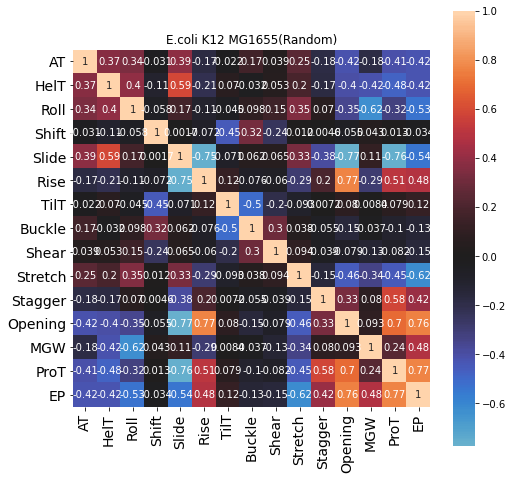

In [46]:
random_shape_avg_df = random_shape_avg_df.astype(float)
random_corr_df = random_shape_avg_df.corr(method='spearman')

_, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(random_corr_df, center=0, annot=True, square=True, ax=ax)
ax.set_title('E.coli K12 MG1655(Random)')
ax.tick_params(axis='both', labelsize=14)
ax.tick_params(axis='y', rotation=0)

## Plot the Shape Values for TSS (and Random Sequences)

In [48]:
from matplotlib.patches import Rectangle

Text(0.5, 0, 'bp from TSS')

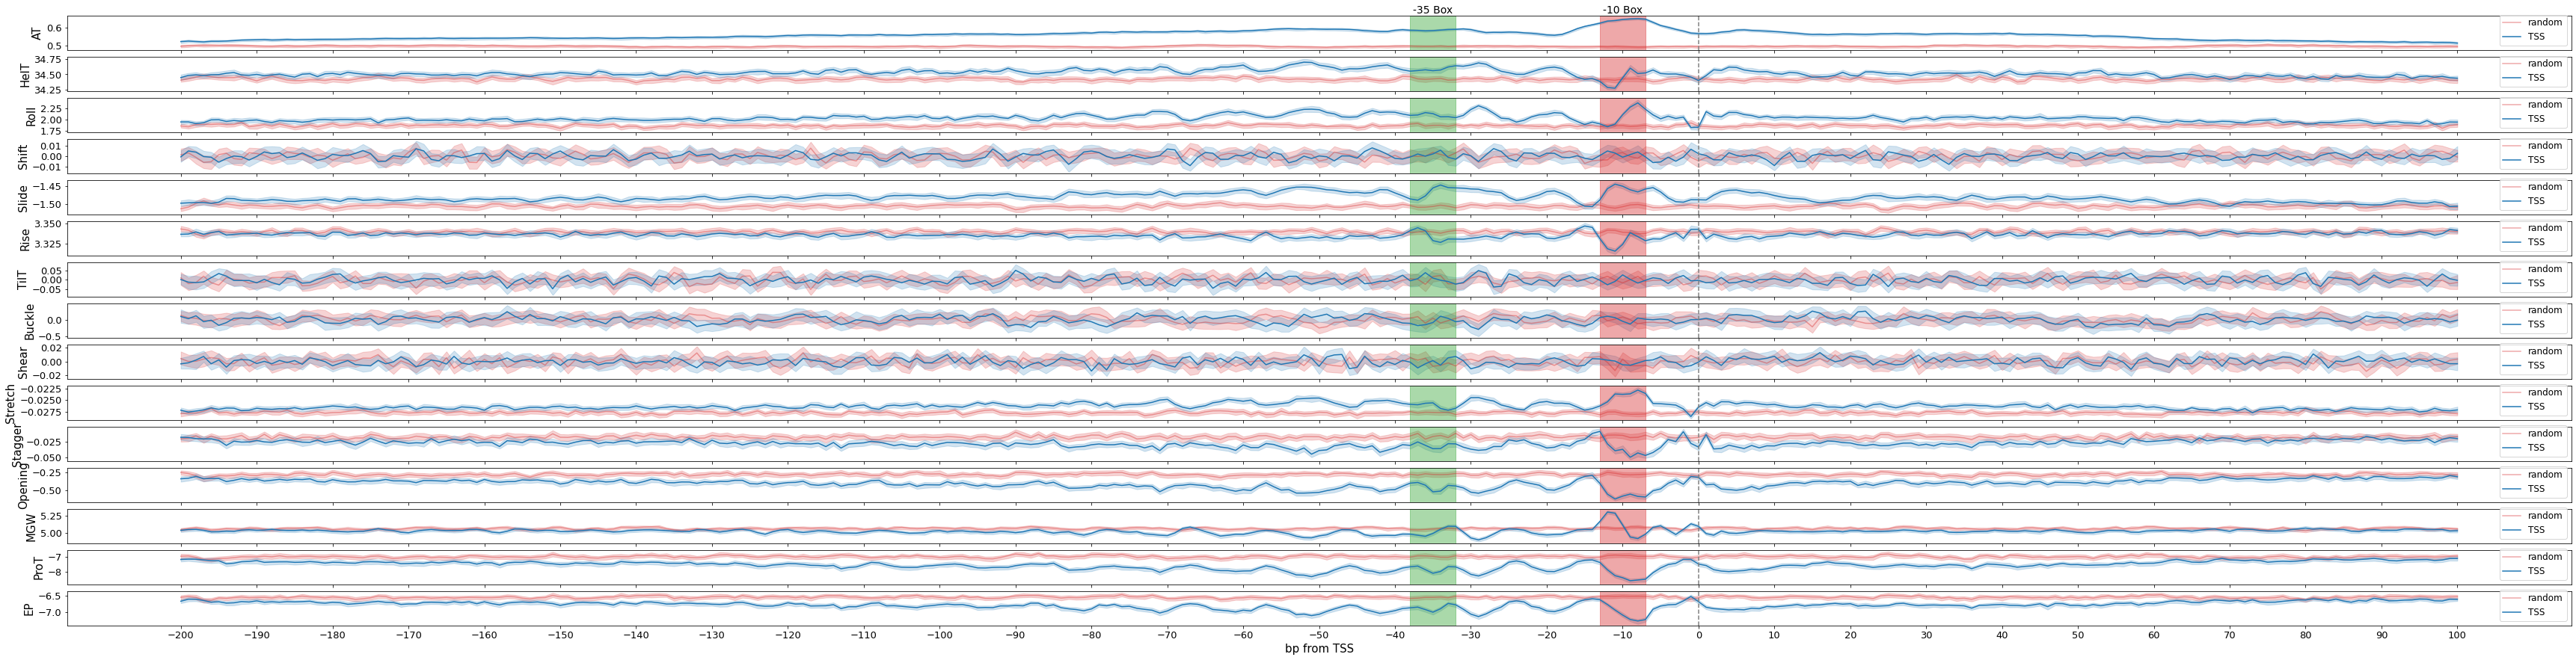

In [50]:
_, axs = plt.subplots(15, 1, figsize=(50, 20), sharex=True)

for ax, shape_name in zip(axs, ['AT'] + shape_names):

    sns.lineplot(x='bp', y=shape_name, data=random_shape_df, estimator='mean', ax=ax, n_boot=100,
                 color='tab:red', alpha=0.4, label='random')
    sns.lineplot(x='bp', y=shape_name, data=upstream_shape_df, estimator='mean', ax=ax, n_boot=100, label='TSS')
    ax.set_ylabel(shape_name, fontsize=15)
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xticks(np.arange(-N_UPSTREAM, N_DOWNSTREAM + 10, 10))
    ax.axvline(0, linestyle='--', color='gray')
    ymin, ymax = ax.get_ylim()
    ax.add_patch(Rectangle((-13, ymin), 6, (ymax-ymin), color='tab:red', alpha=0.4))
    ax.add_patch(Rectangle((-38, ymin), 6, (ymax-ymin), color='tab:green', alpha=0.4))
    ax.legend(loc='lower right', fontsize=12)

ax0_ymin, ax0_ymax = axs[0].get_ylim()
axs[0].text(-10, ax0_ymax+(ax0_ymax-ax0_ymin)*0.07, '-10 Box', fontsize=14, ha='center')
axs[0].text(-35, ax0_ymax+(ax0_ymax-ax0_ymin)*0.07, '-35 Box', fontsize=14, ha='center')    
axs[-1].set_xlabel('bp from TSS', fontsize=15)

# Sigma 70 shape profiling

In [8]:
bitome.genes[3000].transcription_units[0].id

'ECK120009144'

In [9]:
sig_TUs = {'Sigma70':set(),'Sigma38':set(),'Sigma32':set(),'Sigma24':set(),'Sigma28':set(),'Sigma54':set()}
for g in bitome.genes:
    if len(g.transcription_units) < 1:
        continue
    for tu in g.transcription_units:
        if tu.id not in hits_U00096.keys():
            continue
        if tu.sigma_factors==None:
            continue
            
        for sig in tu.sigma_factors:
            if sig in sig_TUs.keys():
                sig_TUs[sig].add( tu.id)  

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


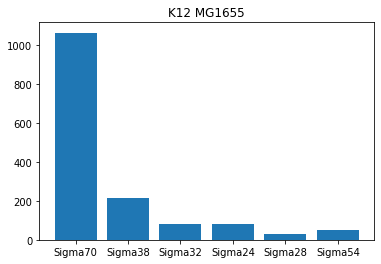

In [10]:
sig_names = list(sig_TUs.keys())
count=[]
for sig in sig_names:
    count.append( len(sig_TUs[sig]) )
plt.bar(sig_names,count)
plt.title('K12 MG1655')
plt.show()

In [11]:
tss_strand_tups_70 = []
tss_strand_tups_38 = []
tss_strand_tups_32 = []
for i in range(len(TU_U00096_table['ID'])):
    tu_tss =   int(TU_U00096_table['TSS_pred'][i])
    tu_strand = int(TU_U00096_table['strand'][i])
    
    if TU_U00096_table['TU_id'][i] in sig_TUs['Sigma70']:
        tss_strand_tups_70.append((tu_tss, tu_strand))
    elif TU_U00096_table['TU_id'][i] in sig_TUs['Sigma38']:
        tss_strand_tups_38.append( (tu_tss, tu_strand) )
    elif TU_U00096_table['TU_id'][i] in sig_TUs['Sigma32']:
        tss_strand_tups_32.append( (tu_tss, tu_strand) )
    
unique_tss_strand_tups_70 = list(set(tss_strand_tups_70))
unique_tss_strand_tups_38 = list(set(tss_strand_tups_38))
unique_tss_strand_tups_32 = list(set(tss_strand_tups_32))

In [15]:
N_UPSTREAM = 60
N_DOWNSTREAM = 20
AT_PLUS_MINUS = 5


shape_names = ['HelT', 'Roll', 'Shift', 'Slide', 'Rise', 'TilT', 'Buckle', 'Shear',
               'Stretch', 'Stagger', 'Opening', 'MGW', 'ProT', 'EP']

up_shape_df = {'Sigma70':pd.DataFrame(columns=(shape_names + ['bp', 'AT'])),
               'Sigma38':pd.DataFrame(columns=(shape_names + ['bp', 'AT'])),
               'Sigma32':pd.DataFrame(columns=(shape_names + ['bp', 'AT']))}

tss_strand_tups_dict = {'Sigma70':unique_tss_strand_tups_70,
                        'Sigma38':unique_tss_strand_tups_38,
                        'Sigma32':unique_tss_strand_tups_32}

for sig in up_shape_df.keys():
    for tss, strand in tss_strand_tups_dict[sig]:

        if strand == 1:

            # ignore the case where we have to wrap around for now; just excludes a couple of TSS
            if tss < N_UPSTREAM:
                continue

            locs = np.arange(tss - N_UPSTREAM, tss + N_DOWNSTREAM + 1)
            bp_to_tss = np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1)

            # define the sequence feature location to extract the sequence around this TSS
            seq_loc = FeatureLocation(
                tss - N_UPSTREAM - AT_PLUS_MINUS - 1,
                tss + N_DOWNSTREAM + AT_PLUS_MINUS,
                strand
            )

        else:

            locs = np.arange(tss - N_DOWNSTREAM, tss + N_UPSTREAM + 1)
            bp_to_tss = np.flip(np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1))

            # define the sequence feature location to extract the sequence around this TSS
            seq_loc = FeatureLocation(
                tss - N_DOWNSTREAM - AT_PLUS_MINUS - 1,
                tss + N_UPSTREAM + AT_PLUS_MINUS,
                strand
            )

        tss_shape_df = get_shape(locs[0], locs[-1], shape ).drop(['loc'],axis=1)
        tss_shape_df['bp'] = bp_to_tss

        sequence = seq_loc.extract(bitome_U00096.sequence)
        at_content = []
        for i in range(AT_PLUS_MINUS, N_UPSTREAM + N_DOWNSTREAM + AT_PLUS_MINUS + 1):
            seq_slice = sequence[i-AT_PLUS_MINUS:i+AT_PLUS_MINUS+1]
            at_count = 0
            for base in seq_slice:
                if base in ['A', 'T']:
                    at_count += 1
            at_content.append(at_count/(2*AT_PLUS_MINUS + 1))

        # we computed AT content in sequence order, REGARDLESS of strand; but we're feeding
        # the bp in reverse order for the reverse strand; swap the AT content list in that case
        if strand == -1:
            at_content.reverse()

        tss_shape_df['AT'] = at_content

        up_shape_df[sig] = up_shape_df[sig].append(tss_shape_df)

    up_shape_df[sig].loc[:, 'Roll'] = up_shape_df[sig]['Roll'].abs()

In [16]:
from matplotlib.patches import Rectangle

Text(0.5, 0, 'bp from TSS')

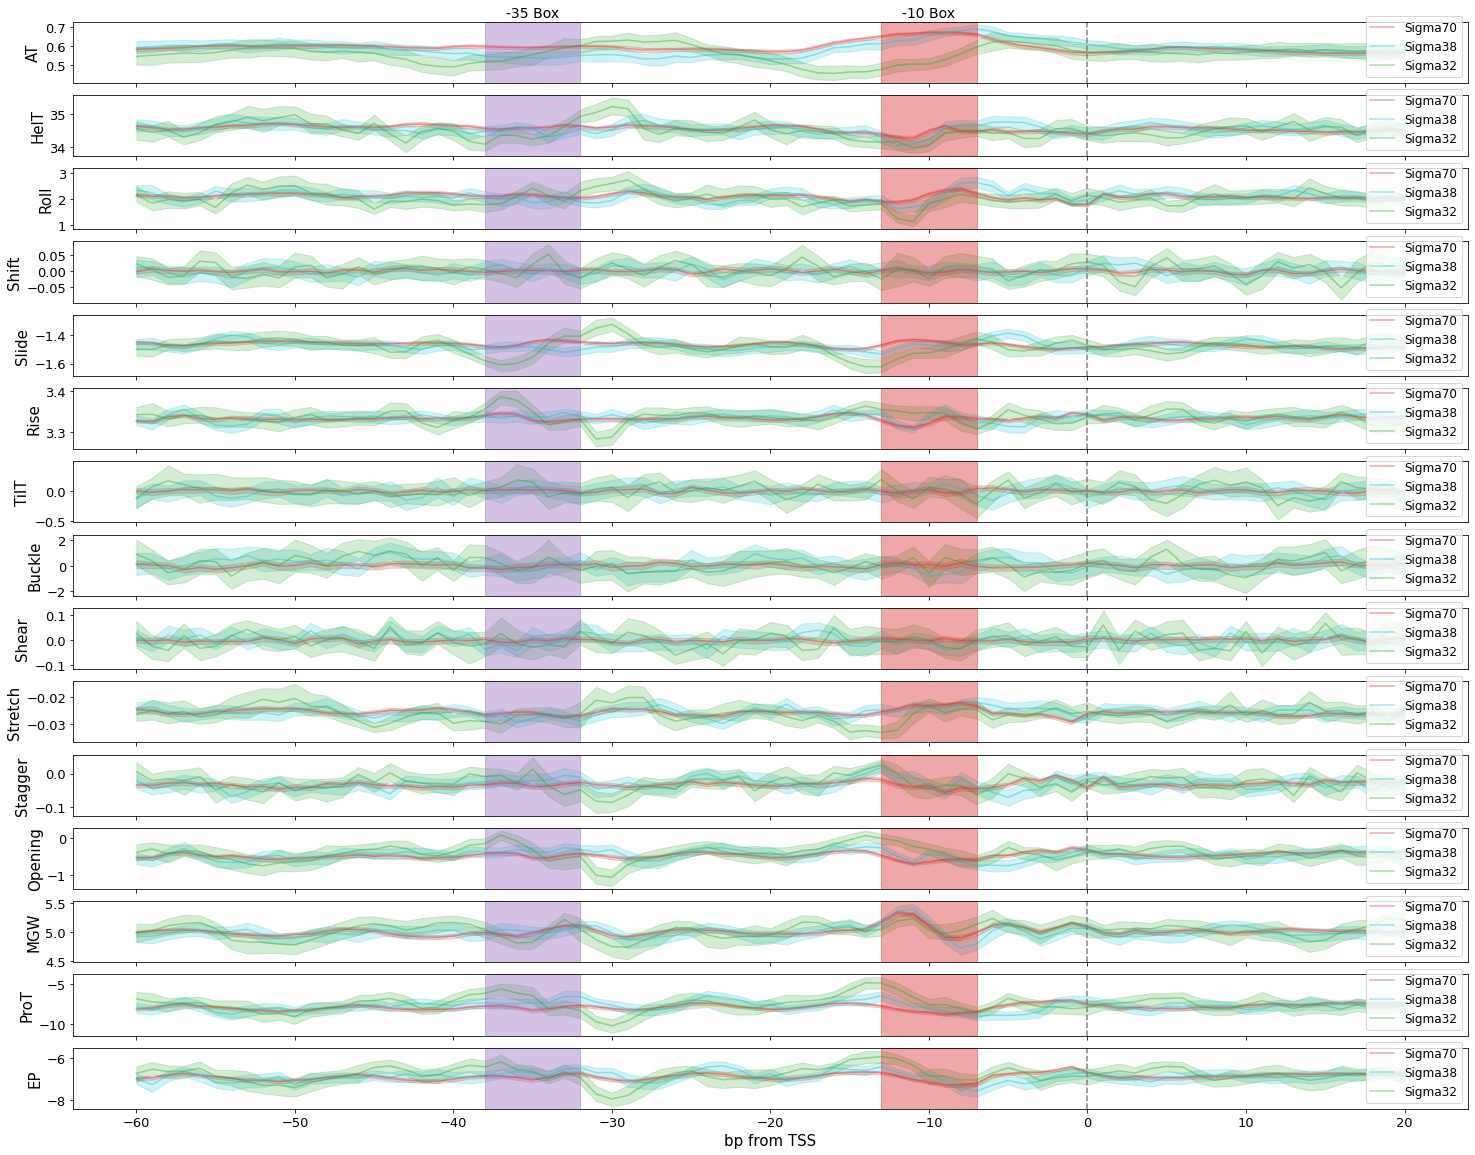

In [22]:
_, axs = plt.subplots(15, 1, figsize=(25, 20), sharex=True)

for ax, shape_name in zip(axs, ['AT'] + shape_names):

    sns.lineplot(x='bp', y=shape_name, data=up_shape_df['Sigma70'], estimator='mean', ax=ax, n_boot=100,
                 color='tab:red', alpha=0.4, label='Sigma70')
    sns.lineplot(x='bp', y=shape_name, data=up_shape_df['Sigma38'], estimator='mean', ax=ax, n_boot=100,
                 color='tab:cyan', alpha=0.4, label='Sigma38')
    sns.lineplot(x='bp', y=shape_name, data=up_shape_df['Sigma32'], estimator='mean', ax=ax, n_boot=100,
                 color='tab:green', alpha=0.4, label='Sigma32')
    
    ax.set_ylabel(shape_name, fontsize=15)
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xticks(np.arange(-N_UPSTREAM, N_DOWNSTREAM + 10, 10))
    ax.axvline(0, linestyle='--', color='gray')
    ymin, ymax = ax.get_ylim()
    ax.add_patch(Rectangle((-13, ymin), 6, (ymax-ymin), color='tab:red', alpha=0.4))
    ax.add_patch(Rectangle((-38, ymin), 6, (ymax-ymin), color='tab:purple', alpha=0.4))
    ax.legend(loc='lower right', fontsize=12)

ax0_ymin, ax0_ymax = axs[0].get_ylim()
axs[0].text(-10, ax0_ymax+(ax0_ymax-ax0_ymin)*0.07, '-10 Box', fontsize=14, ha='center')
axs[0].text(-35, ax0_ymax+(ax0_ymax-ax0_ymin)*0.07, '-35 Box', fontsize=14, ha='center')    
axs[-1].set_xlabel('bp from TSS', fontsize=15)

# TFBS shape

In [15]:
# generate random data for comparison
N_UPSTREAM = 25
N_DOWNSTREAM = 25
AT_PLUS_MINUS = 5

N_BOOTSTRAP = 300
shape_names = ['HelT', 'Roll', 'Slide', 'Stretch', 'Stagger', 'Opening', 'MGW', 'ProT', 'EP']

random_site_strand_tups = []
buffer = max(N_UPSTREAM, N_DOWNSTREAM)
site_pool = np.arange(buffer, len(bitome_U00096.sequence) - buffer)
for i in range(N_BOOTSTRAP):
    site = int(np.random.choice( site_pool))
    strand = int(np.random.choice([-1, 1]))
    random_site_strand_tups.append(( site , strand))

random_site_df = pd.DataFrame(columns=(shape_names + ['bp', 'AT']))

for site, strand in random_site_strand_tups:

    if strand == 1:
        
        # ignore the case where we have to wrap around for now; just excludes a couple of TSS
        if site < N_UPSTREAM:
            continue
        
        locs = np.arange(site - N_UPSTREAM, site + N_DOWNSTREAM + 1)
        bp_to_site = np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1)
        
        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            site - N_UPSTREAM - AT_PLUS_MINUS - 1,
            site + N_DOWNSTREAM + AT_PLUS_MINUS,
            strand
        )
        
    else:

        locs = np.arange( site - N_DOWNSTREAM, site + N_UPSTREAM + 1)
        bp_to_site = np.flip(np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1))

        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            site - N_DOWNSTREAM - AT_PLUS_MINUS - 1,
            site + N_UPSTREAM + AT_PLUS_MINUS,
            strand
        )
    
   
    site_shape_df = get_shape(locs[0], locs[-1], shape ).drop(['Rise','Shift', 'TilT', 'Buckle', 'Shear','loc'],axis=1)
    site_shape_df['bp'] = bp_to_site
    
    sequence = seq_loc.extract(bitome_U00096.sequence)
    at_content = []
    for i in range(AT_PLUS_MINUS, N_UPSTREAM + N_DOWNSTREAM + AT_PLUS_MINUS + 1):
        seq_slice = sequence[i-AT_PLUS_MINUS:i+AT_PLUS_MINUS+1]
        at_count = 0
        for base in seq_slice:
            if base in ['A', 'T']:
                at_count += 1
        at_content.append(at_count/(2*AT_PLUS_MINUS + 1))
    
    if strand == -1:
        at_content.reverse()
    
    site_shape_df['AT'] = at_content
    
    random_site_df = random_site_df.append( site_shape_df )

random_site_df.loc[:, 'Roll'] = random_site_df['Roll'].abs()

In [16]:
from feature_functions import *

In [17]:
pwm_db = rpwm('data/motif_pwm_db.txt')
tf_list = list(pwm_db.keys())
print(tf_list)
tf_site_strand_tups = {}
for tf in tf_list:
    tf_site_strand_tups[tf] = []

['AraC', 'ArcA', 'ArgP', 'ArgR', 'BaeR', 'BasR', 'CysB', 'CpxR', 'Cra', 'Crp', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 'IHF', 'FhlA', 'FlhDC', 'Fnr', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 'Nac', 'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OmpR', 'OxyR', 'PdhR', 'PhoB', 'PhoP', 'PurR', 'PuuR', 'RcsAB', 'RhaS', 'RutR', 'SoxS', 'TrpR', 'XylR', 'YdeO']


In [18]:
TFBS = pd.read_csv('data/TFBS.csv')
TFBS = pd.concat( [ TFBS.loc[ TFBS['Evidence confidence level'] == 'Strong'], TFBS.loc[ TFBS['Evidence confidence level'] == 'Confirmed'] ])
TFBS = TFBS.reset_index()
TFBS = TFBS.drop(columns=['index'],axis=1)
TFBS

TF name  TF-bs left end  TF-bs right end   strand  \
0       AcrR          485709           485732  reverse   
1       AcrR          485709           485732  forward   
2       AcrR         1619048          1619058  forward   
3       AcrR         4277444          4277454  forward   
4       AcrR         4277444          4277454  reverse   
...      ...             ...              ...      ...   
2238    PyrR         3712091          3712101  reverse   
2239    PyrR         3712112          3712122  reverse   
2240    TorR         1057973          1057982  reverse   
2241    TorR         1057973          1057982  forward   
2242    UlaR         4419873          4419892  forward   

     Evidence confidence level  
0                       Strong  
1                       Strong  
2                       Strong  
3                       Strong  
4                       Strong  
...                        ...  
2238                 Confirmed  
2239                 Confirmed  
2240                 Confirmed  
2241                 Confirmed  
2242                 Confirmed  

[2243 rows x 5 columns]

In [19]:
# tuple format = (left,right, strand )
for i in range(len(TFBS['TF name'])):
    if TFBS['strand'][i] == 'reverse':
        strand = -1
    else:
        strand = 1
    if TFBS['TF name'][i] in tf_list:
        tf_site_strand_tups[ TFBS['TF name'][i] ].append( ( int(TFBS['TF-bs left end'][i]),
                                                           int(TFBS['TF-bs right end'][i]), strand ) )

In [20]:
tfToDo = ['Crp','Fnr','ArcA','ArgR','Lrp','AraC','TyrR','Fur']
N_UPSTREAM = 25
N_DOWNSTREAM = 25
AT_PLUS_MINUS = 5
# remove Shift, TilT, Buckle, Shear
shape_names = ['HelT', 'Roll', 'Slide', 'Stretch', 'Stagger', 'Opening', 'MGW', 'ProT', 'EP']

TFBS_shape_df ={}
for tf in tfToDo:
    TFBS_shape_df[tf] = pd.DataFrame(columns=(shape_names + ['bp', 'AT']))
    
motif_seqs = {}
for tf in tfToDo:
    motif_seqs[tf] = []
    
for tf in tfToDo:
    for left, right, strand in tf_site_strand_tups[tf]:
        mid = int( (left+right)/2 )

        if strand == 1:

            # ignore the case where we have to wrap around for now; just excludes a couple of TSS
            if mid < N_UPSTREAM:
                continue

            locs = np.arange(mid - N_UPSTREAM, mid + N_DOWNSTREAM + 1)
            bp_to_mid = np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1)

            # define the sequence feature location to extract the sequence around this TSS
            seq_loc = FeatureLocation(
                mid - N_UPSTREAM - AT_PLUS_MINUS - 1,
                mid + N_DOWNSTREAM + AT_PLUS_MINUS,
                strand
            )

        else:

            locs = np.arange(mid - N_DOWNSTREAM, mid + N_UPSTREAM + 1)
            bp_to_mid = np.flip(np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1))

            # define the sequence feature location to extract the sequence around this TSS
            seq_loc = FeatureLocation(
                mid - N_DOWNSTREAM - AT_PLUS_MINUS - 1,
                mid + N_UPSTREAM + AT_PLUS_MINUS,
                strand
            )

        tf_shape_df = get_shape(locs[0], locs[-1], shape ).drop(['Rise','Shift', 'TilT', 'Buckle', 'Shear','loc'],axis=1)
        tf_shape_df['bp'] = bp_to_mid

        sequence = seq_loc.extract(bitome_U00096.sequence)
        motif_seqs[tf].append( str( sequence[AT_PLUS_MINUS:len(sequence)-AT_PLUS_MINUS] )  )
        
        at_content = []
        for i in range(AT_PLUS_MINUS, N_UPSTREAM + N_DOWNSTREAM + AT_PLUS_MINUS + 1):
            seq_slice = sequence[i-AT_PLUS_MINUS:i+AT_PLUS_MINUS+1]
            at_count = 0
            for base in seq_slice:
                if base in ['A', 'T']:
                    at_count += 1
            at_content.append(at_count/(2*AT_PLUS_MINUS + 1))

        # we computed AT content in sequence order, REGARDLESS of strand; but we're feeding
        # the bp in reverse order for the reverse strand; swap the AT content list in that case
        if strand == -1:
            at_content.reverse()

        tf_shape_df['AT'] = at_content

        TFBS_shape_df[tf] = TFBS_shape_df[tf].append(tf_shape_df)
        
    TFBS_shape_df[tf].loc[:, 'Roll'] = TFBS_shape_df[tf]['Roll'].abs()

In [21]:
tfToDo = ['Crp','Fnr','ArcA','ArgR','Lrp','AraC','TyrR','Fur']
shape_names = ['HelT', 'Roll', 'Slide', 'Stretch', 'Stagger', 'Opening', 'MGW', 'ProT', 'EP']

In [22]:
counts_mat = lm.alignment_to_matrix(motif_seqs['Crp'])

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.


Text(0, 0.5, 'PWM')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


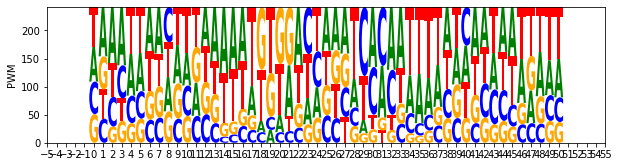

In [23]:
lm.Logo(counts_mat)
plt.xticks(np.arange(-5,56,1),);
plt.ylabel('PWM')

In [24]:
PWMs = {}
for tf in motif_seqs.keys():
    PWMs[tf] = motifs.create( motif_seqs[tf]).pwm    

In [25]:
def consensus_seq( pwm ):
    seq = ''
    for i in range(len(pwm['A'])):
        if pwm['A'][i] == max([pwm['A'][i],pwm['C'][i],pwm['G'][i],pwm['T'][i]] ):
            seq = seq + 'A'
        elif pwm['C'][i] == max([pwm['A'][i],pwm['C'][i],pwm['G'][i],pwm['T'][i]] ):
            seq = seq + 'C'
        elif pwm['G'][i] == max([pwm['A'][i],pwm['C'][i],pwm['G'][i],pwm['T'][i]] ):
            seq = seq + 'G'
        else:
            seq = seq + 'T'
    return seq

In [26]:
con_seqs = {}
for tf in PWMs.keys():
    con_seqs[tf] = consensus_seq( PWMs[tf] )

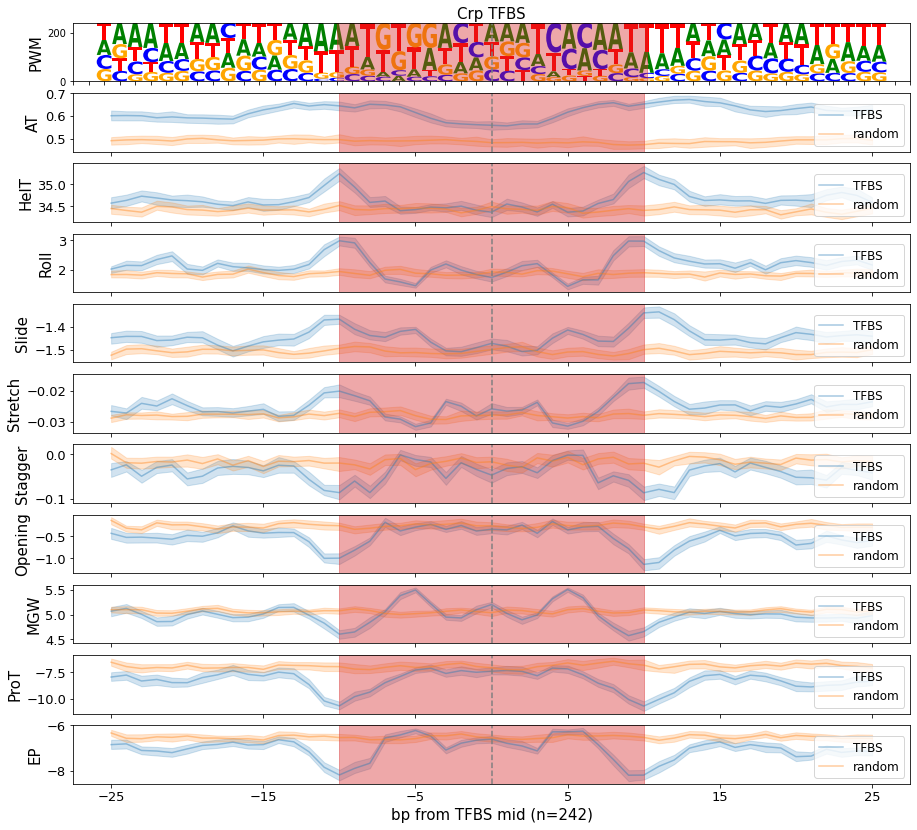

In [20]:
counts_mat = lm.alignment_to_matrix(motif_seqs['Crp'])

_, axs = plt.subplots(11, 1, figsize=(15, 14) )
width = len(pwm_db['Crp'])
for ax, shape_name in zip(axs[1:11],['AT'] + shape_names):

    sns.lineplot(x='bp', y=shape_name, data=TFBS_shape_df['Crp'], estimator='mean', ax=ax, n_boot=100,
                 color='tab:blue', alpha=0.4, label='TFBS')
    
    sns.lineplot(x='bp', y=shape_name, data=random_site_df, estimator='mean', ax=ax, n_boot=100,
                 color='tab:orange', alpha=0.4, label='random')
    
    ax.set_ylabel(shape_name, fontsize=15)
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xticks( np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1, 10) )
    ax.axvline(0, linestyle='--', color='gray')
    ymin, ymax = ax.get_ylim()
    ax.add_patch(Rectangle((- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))
    ax.legend(loc='lower right', fontsize=12)
    
lm.Logo(counts_mat, ax = axs[0]);
axs[0].set_ylabel('PWM', fontsize=15)
axs[0].tick_params(axis='x', labelsize=1)
axs[0].set_xticks( np.arange(-2, 53, 1) )
axs[0].axvline(25, linestyle='--', color='gray')
ymin, ymax = axs[0].get_ylim()
axs[0].add_patch(Rectangle((25- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))

ax0_ymin, ax0_ymax = axs[0].get_ylim()
axs[0].text(25, ax0_ymax+(ax0_ymax-ax0_ymin)*0.07,'Crp TFBS', fontsize=15, ha='center')  
axs[-1].set_xlabel('bp from TFBS mid (n='+str(len(tf_site_strand_tups['Crp']))+')', fontsize=15)

for ax in axs[0:10]:
    plt.setp(ax.get_xticklabels(), visible=False )

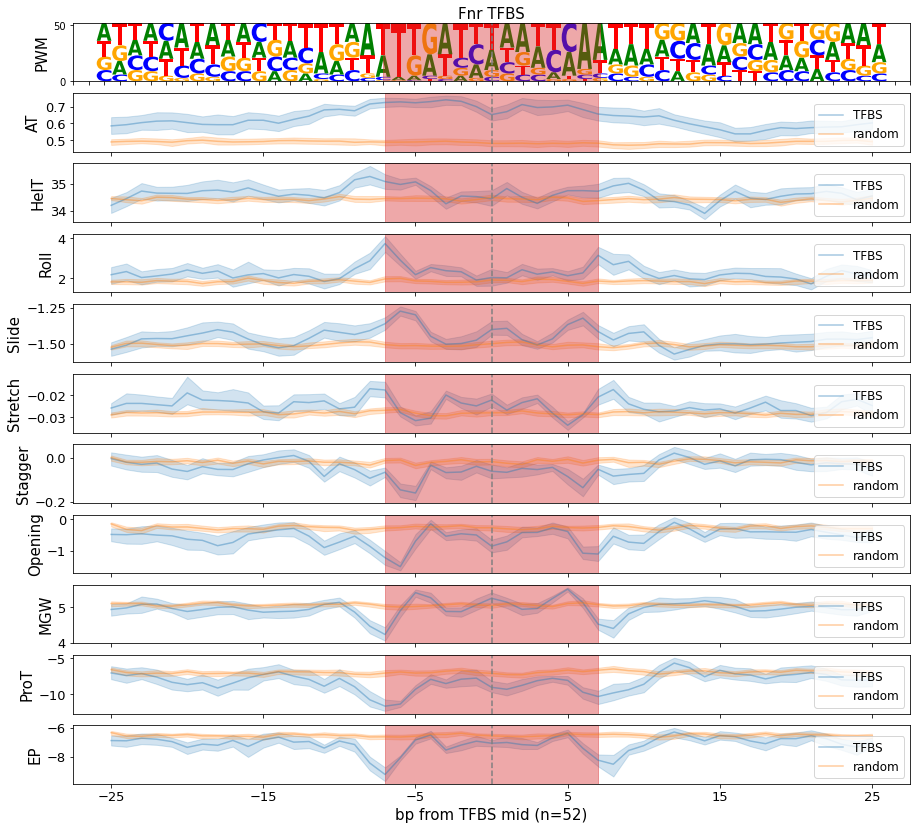

In [21]:
counts_mat = lm.alignment_to_matrix(motif_seqs['Fnr'])

_, axs = plt.subplots(11, 1, figsize=(15, 14) )
width = len(pwm_db['Fnr'])
for ax, shape_name in zip(axs[1:11],['AT'] + shape_names):

    sns.lineplot(x='bp', y=shape_name, data=TFBS_shape_df['Fnr'], estimator='mean', ax=ax, n_boot=100,
                 color='tab:blue', alpha=0.4, label='TFBS')
    sns.lineplot(x='bp', y=shape_name, data=random_site_df, estimator='mean', ax=ax, n_boot=100,
                 color='tab:orange', alpha=0.4, label='random')
    ax.set_ylabel(shape_name, fontsize=15)
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xticks( np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1, 10) )
    ax.axvline(0, linestyle='--', color='gray')
    ymin, ymax = ax.get_ylim()
    ax.add_patch(Rectangle((- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))
    ax.legend(loc='lower right', fontsize=12)
    
lm.Logo(counts_mat, ax = axs[0]);
axs[0].set_ylabel('PWM', fontsize=15)
axs[0].tick_params(axis='x', labelsize=1)
axs[0].set_xticks( np.arange(-2, 53, 1) )
axs[0].axvline(25, linestyle='--', color='gray')
ymin, ymax = axs[0].get_ylim()
axs[0].add_patch(Rectangle((25- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))

ax0_ymin, ax0_ymax = axs[0].get_ylim()
axs[0].text(25, ax0_ymax+(ax0_ymax-ax0_ymin)*0.07,'Fnr TFBS', fontsize=15, ha='center')  
axs[-1].set_xlabel('bp from TFBS mid (n='+str(len(tf_site_strand_tups['Fnr']))+')', fontsize=15)

for ax in axs[0:10]:
    plt.setp(ax.get_xticklabels(), visible=False )

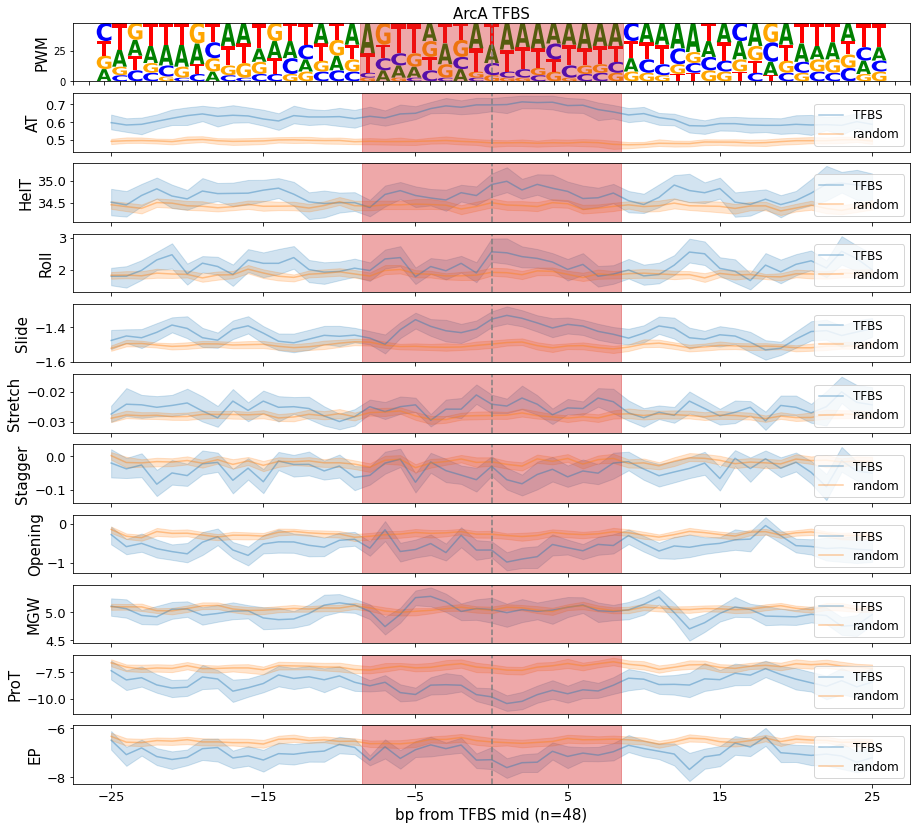

In [26]:
counts_mat = lm.alignment_to_matrix(motif_seqs['ArcA'])

_, axs = plt.subplots(11, 1, figsize=(15, 14) )
width = len(pwm_db['ArcA'])
for ax, shape_name in zip(axs[1:11],['AT'] + shape_names):

    sns.lineplot(x='bp', y=shape_name, data=TFBS_shape_df['ArcA'], estimator='mean', ax=ax, n_boot=100,
                 color='tab:blue', alpha=0.4, label='TFBS')
    sns.lineplot(x='bp', y=shape_name, data=random_site_df, estimator='mean', ax=ax, n_boot=100,
                 color='tab:orange', alpha=0.4, label='random')
    ax.set_ylabel(shape_name, fontsize=15)
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xticks( np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1, 10) )
    ax.axvline(0, linestyle='--', color='gray')
    ymin, ymax = ax.get_ylim()
    ax.add_patch(Rectangle((- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))
    ax.legend(loc='lower right', fontsize=12)
    
lm.Logo(counts_mat, ax = axs[0]);
axs[0].set_ylabel('PWM', fontsize=15)
axs[0].tick_params(axis='x', labelsize=1)
axs[0].set_xticks( np.arange(-2, 53, 1) )
axs[0].axvline(25, linestyle='--', color='gray')
ymin, ymax = axs[0].get_ylim()
axs[0].add_patch(Rectangle((25- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))

ax0_ymin, ax0_ymax = axs[0].get_ylim()
axs[0].text(25, ax0_ymax+(ax0_ymax-ax0_ymin)*0.07,'ArcA TFBS', fontsize=15, ha='center')  
axs[-1].set_xlabel('bp from TFBS mid (n='+str(len(tf_site_strand_tups['ArcA']))+')', fontsize=15)

for ax in axs[0:10]:
    plt.setp(ax.get_xticklabels(), visible=False )

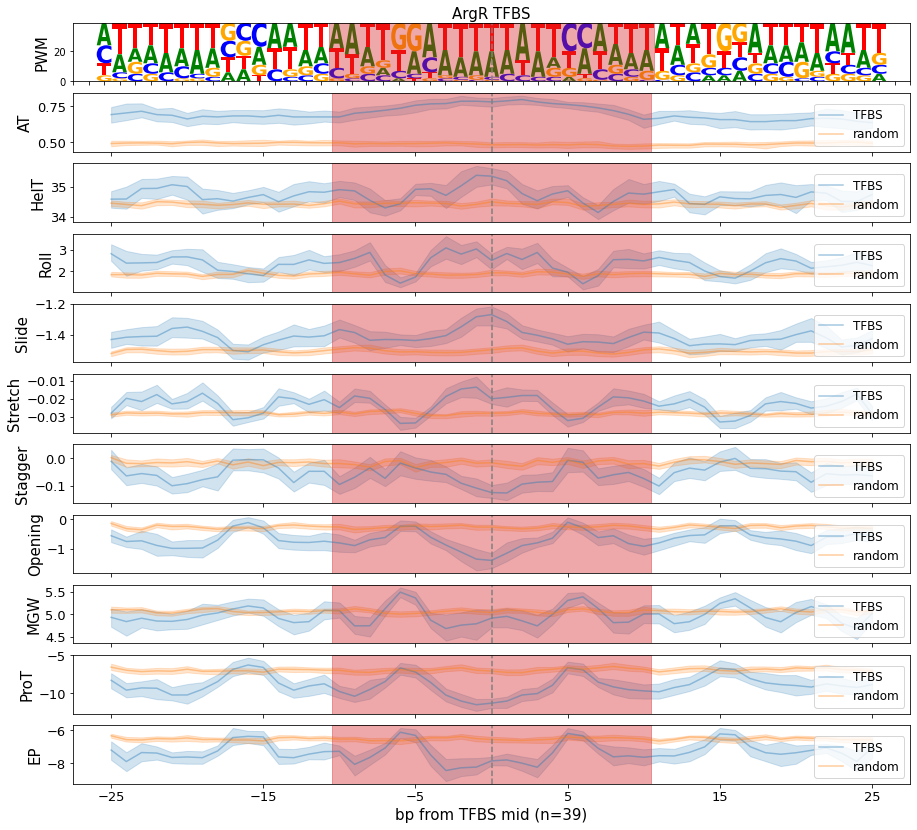

In [27]:
counts_mat = lm.alignment_to_matrix(motif_seqs['ArgR'])

_, axs = plt.subplots(11, 1, figsize=(15, 14) )
width = len(pwm_db['ArgR'])
for ax, shape_name in zip(axs[1:11],['AT'] + shape_names):

    sns.lineplot(x='bp', y=shape_name, data=TFBS_shape_df['ArgR'], estimator='mean', ax=ax, n_boot=100,
                 color='tab:blue', alpha=0.4, label='TFBS')
    sns.lineplot(x='bp', y=shape_name, data=random_site_df, estimator='mean', ax=ax, n_boot=100,
                 color='tab:orange', alpha=0.4, label='random')
        
    ax.set_ylabel(shape_name, fontsize=15)
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xticks( np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1, 10) )
    ax.axvline(0, linestyle='--', color='gray')
    ymin, ymax = ax.get_ylim()
    ax.add_patch(Rectangle((- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))
    ax.legend(loc='lower right', fontsize=12)
    
lm.Logo(counts_mat, ax = axs[0]);
axs[0].set_ylabel('PWM', fontsize=15)
axs[0].tick_params(axis='x', labelsize=1)
axs[0].set_xticks( np.arange(-2, 53, 1) )
axs[0].axvline(25, linestyle='--', color='gray')
ymin, ymax = axs[0].get_ylim()
axs[0].add_patch(Rectangle((25- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))

ax0_ymin, ax0_ymax = axs[0].get_ylim()
axs[0].text(25, ax0_ymax+(ax0_ymax-ax0_ymin)*0.07,'ArgR TFBS', fontsize=15, ha='center')  
axs[-1].set_xlabel('bp from TFBS mid (n='+str(len(tf_site_strand_tups['ArgR']))+')', fontsize=15)

for ax in axs[0:10]:
    plt.setp(ax.get_xticklabels(), visible=False )

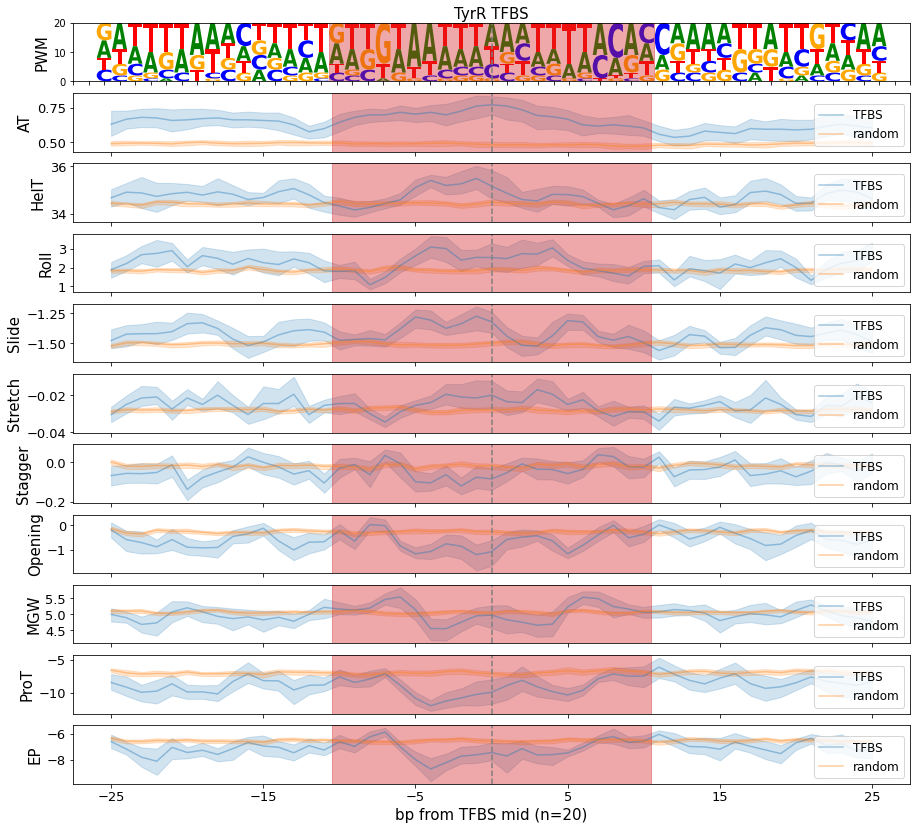

In [29]:
counts_mat = lm.alignment_to_matrix(motif_seqs['TyrR'])

_, axs = plt.subplots(11, 1, figsize=(15, 14) )
width = len(pwm_db['TyrR'])
for ax, shape_name in zip(axs[1:11],['AT'] + shape_names):

    sns.lineplot(x='bp', y=shape_name, data=TFBS_shape_df['TyrR'], estimator='mean', ax=ax, n_boot=100,
                 color='tab:blue', alpha=0.4, label='TFBS')
    sns.lineplot(x='bp', y=shape_name, data=random_site_df, estimator='mean', ax=ax, n_boot=100,
                 color='tab:orange', alpha=0.4, label='random')
    ax.set_ylabel(shape_name, fontsize=15)
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xticks( np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1, 10) )
    ax.axvline(0, linestyle='--', color='gray')
    ymin, ymax = ax.get_ylim()
    ax.add_patch(Rectangle((- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))
    ax.legend(loc='lower right', fontsize=12)
    
lm.Logo(counts_mat, ax = axs[0]);
axs[0].set_ylabel('PWM', fontsize=15)
axs[0].tick_params(axis='x', labelsize=1)
axs[0].set_xticks( np.arange(-2, 53, 1) )
axs[0].axvline(25, linestyle='--', color='gray')
ymin, ymax = axs[0].get_ylim()
axs[0].add_patch(Rectangle((25- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))

ax0_ymin, ax0_ymax = axs[0].get_ylim()
axs[0].text(25, ax0_ymax+(ax0_ymax-ax0_ymin)*0.07,'TyrR TFBS', fontsize=15, ha='center')  
axs[-1].set_xlabel('bp from TFBS mid (n='+str(len(tf_site_strand_tups['TyrR']))+')', fontsize=15)

for ax in axs[0:10]:
    plt.setp(ax.get_xticklabels(), visible=False )

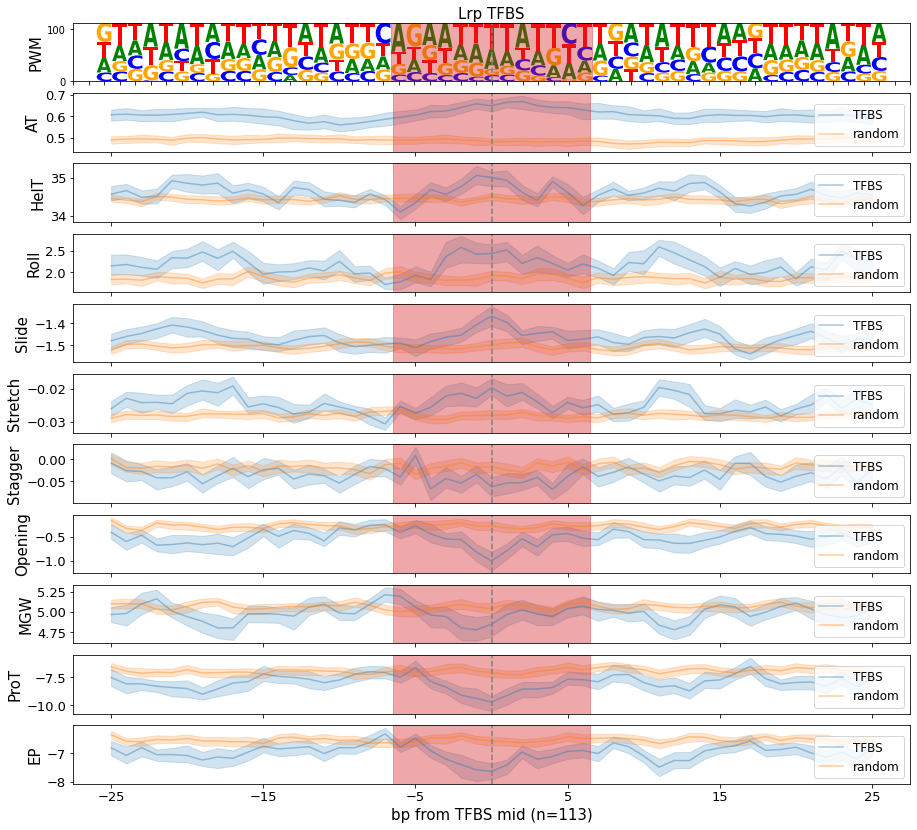

In [30]:
counts_mat = lm.alignment_to_matrix(motif_seqs['Lrp'])

_, axs = plt.subplots(11, 1, figsize=(15, 14) )
width = len(pwm_db['Lrp'])
for ax, shape_name in zip(axs[1:11],['AT'] + shape_names):

    sns.lineplot(x='bp', y=shape_name, data=TFBS_shape_df['Lrp'], estimator='mean', ax=ax, n_boot=100,
                 color='tab:blue', alpha=0.4, label='TFBS')
    sns.lineplot(x='bp', y=shape_name, data=random_site_df, estimator='mean', ax=ax, n_boot=100,
                 color='tab:orange', alpha=0.4, label='random')
    ax.set_ylabel(shape_name, fontsize=15)
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xticks( np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1, 10) )
    ax.axvline(0, linestyle='--', color='gray')
    ymin, ymax = ax.get_ylim()
    ax.add_patch(Rectangle((- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))
    ax.legend(loc='lower right', fontsize=12)
    
lm.Logo(counts_mat, ax = axs[0]);
axs[0].set_ylabel('PWM', fontsize=15)
axs[0].tick_params(axis='x', labelsize=1)
axs[0].set_xticks( np.arange(-2, 53, 1) )
axs[0].axvline(25, linestyle='--', color='gray')
ymin, ymax = axs[0].get_ylim()
axs[0].add_patch(Rectangle((25- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))

ax0_ymin, ax0_ymax = axs[0].get_ylim()
axs[0].text(25, ax0_ymax+(ax0_ymax-ax0_ymin)*0.07,'Lrp TFBS', fontsize=15, ha='center')  
axs[-1].set_xlabel('bp from TFBS mid (n='+str(len(tf_site_strand_tups['Lrp']))+')', fontsize=15)

for ax in axs[0:10]:
    plt.setp(ax.get_xticklabels(), visible=False )

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


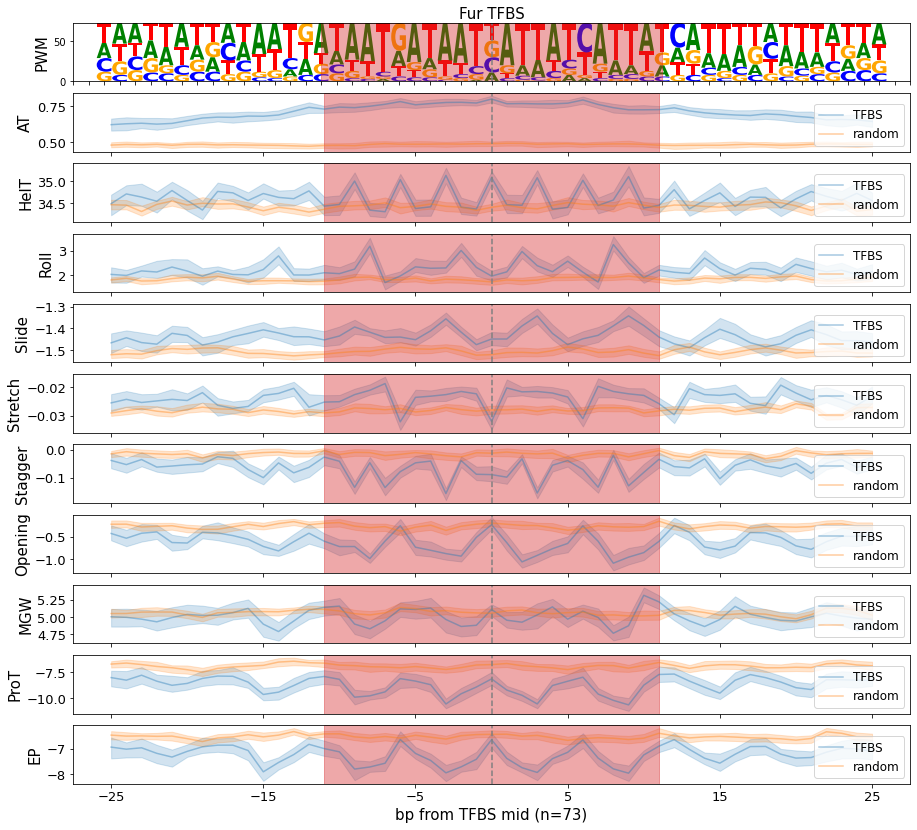

In [27]:
counts_mat = lm.alignment_to_matrix(motif_seqs['Fur'])

_, axs = plt.subplots(11, 1, figsize=(15, 14) )
width = len(pwm_db['Fur'])
for ax, shape_name in zip(axs[1:11],['AT'] + shape_names):

    sns.lineplot(x='bp', y=shape_name, data=TFBS_shape_df['Fur'], estimator='mean', ax=ax, n_boot=100,
                 color='tab:blue', alpha=0.4, label='TFBS')
    sns.lineplot(x='bp', y=shape_name, data=random_site_df, estimator='mean', ax=ax, n_boot=100,
                 color='tab:orange', alpha=0.4, label='random')
    ax.set_ylabel(shape_name, fontsize=15)
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xticks( np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1, 10) )
    ax.axvline(0, linestyle='--', color='gray')
    ymin, ymax = ax.get_ylim()
    ax.add_patch(Rectangle((- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))
    ax.legend(loc='lower right', fontsize=12)
    
lm.Logo(counts_mat, ax = axs[0]);
axs[0].set_ylabel('PWM', fontsize=15)
axs[0].tick_params(axis='x', labelsize=1)
axs[0].set_xticks( np.arange(-2, 53, 1) )
axs[0].axvline(25, linestyle='--', color='gray')
ymin, ymax = axs[0].get_ylim()
axs[0].add_patch(Rectangle((25- (width/2), ymin),width, (ymax-ymin), color='tab:red', alpha=0.4))

ax0_ymin, ax0_ymax = axs[0].get_ylim()
axs[0].text(25, ax0_ymax+(ax0_ymax-ax0_ymin)*0.07,'Fur TFBS', fontsize=15, ha='center')  
axs[-1].set_xlabel('bp from TFBS mid (n='+str(len(tf_site_strand_tups['Fur']))+')', fontsize=15)

for ax in axs[0:10]:
    plt.setp(ax.get_xticklabels(), visible=False )